Se encontraron 72 archivos
Shape del dataset: (72, 75, 75)


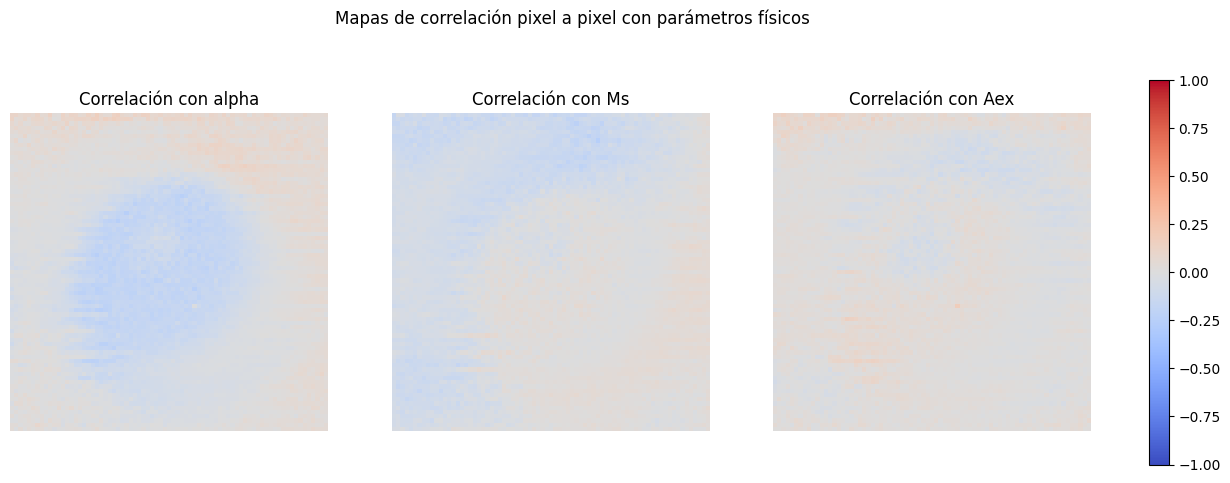

In [ ]:
# =============================================
# 04_xmcd_pixelwise_correlations.ipynb
# Mapas de correlación pixel a pixel con parámetros físicos
# =============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
import seaborn as sns

# --- 1. Cargar archivos HDF5 ---
data_path = Path("../data_raw/xmcd")
files = sorted(data_path.glob("*.hdf5"))
print(f"Se encontraron {len(files)} archivos")

def load_hdf5_image(file, key="entry1/analog0/data"):
    with h5py.File(file, "r") as f:
        data = np.array(f[key])
    if data.ndim == 3:
        return data[0]
    return data

# --- 2. A numpy ---
imgs = []
for f in files:
    imgs.append(load_hdf5_image(f))
imgs = np.array(imgs)  # shape: (N, H, W)
print("Shape del dataset:", imgs.shape)

N, H, W = imgs.shape  # N=72, H=W=75 aprox

# --- 3. Generar parámetros físicos ---
np.random.seed(42)
params = pd.DataFrame({
    "alpha": np.random.uniform(0.01, 0.1, size=N),
    "Ms": np.random.uniform(800e3, 1200e3, size=N),
    "Aex": np.random.uniform(1e-12, 5e-12, size=N)
})

# --- 4. Función para calcular mapas de correlación ---
def correlation_map(imgs, target):
    """Calcula mapa de correlación pixel a pixel entre imágenes y un parámetro."""
    N, H, W = imgs.shape
    corr_map = np.zeros((H, W))

    for i in range(H):
        for j in range(W):
            pix_series = imgs[:, i, j]  # intensidades en este pixel para todos los archivos
            corr = np.corrcoef(pix_series, target)[0, 1]
            corr_map[i, j] = corr
    return corr_map

# --- 5. Generar mapas para cada parámetro ---
maps = {}
for param in ["alpha", "Ms", "Aex"]:
    maps[param] = correlation_map(imgs, params[param].values)

# --- 6. Visualizar resultados ---
fig, axes = plt.subplots(1, 3, figsize=(15,5))

for ax, (param, cmap) in zip(axes, maps.items()):
    im = ax.imshow(cmap, cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_title(f"Correlación con {param}")
    ax.axis("off")

fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02)
plt.suptitle("Mapas de correlación pixel a pixel con parámetros físicos", y=1.02)
plt.show()
